<a href="https://colab.research.google.com/github/Mmiglio/SpeechRecognition/blob/audio_features/notebooks/Audio_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/audio_features/src/analysisFunctions.py

## Download speech data

In [0]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train


In [0]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test']) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))

In [0]:
trainDF.head()

## Tensorflow 2.0

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

## Input pipeline

In [0]:
!pip install -q python_speech_features

In [0]:
!pip install -q librosa

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 100000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    feature='rhythm'
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    feature='rhythm'
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False,
    feature='rhythm'
) 


TypeError: ignored

## Model

In [0]:
from models import cnnModel

model = cnnModel()

model.summary()

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])

In [0]:
EPOCHS = 40

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("bestCnnModel.h5", monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])



Epoch 1/40
1596/1596 [==============================] - 376s 236ms/step - loss: 1.0094 - sparse_categorical_accuracy: 0.7033 - val_loss: 0.5485 - val_sparse_categorical_accuracy: 0.8376
Epoch 2/40
1596/1596 [==============================] - 98s 61ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.9104
Epoch 3/40
1596/1596 [==============================] - 97s 61ms/step - loss: 0.2614 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.2789 - val_sparse_categorical_accuracy: 0.9180
Epoch 4/40
1596/1596 [==============================] - 96s 60ms/step - loss: 0.2265 - sparse_categorical_accuracy: 0.9320 - val_loss: 0.2042 - val_sparse_categorical_accuracy: 0.9413
Epoch 5/40
1596/1596 [==============================] - 96s 60ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9405 - val_loss: 0.2656 - val_sparse_categorical_accuracy: 0.9185
Epoch 6/40
1596/1596 [==============================] - 96s 60ms/step - loss: 

## Save model and trainign history  to drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/gdrive/My\ Drive/speechRecognition/cnnModel

mkdir: cannot create directory ‘/content/gdrive/My Drive/speechRecognition/cnnModel’: File exists


In [0]:
GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/cnnModel/"

## Save model 
model_json = model.to_json()
with open(GDRIVE_PATH + "model.json", "w") as file:
    file.write(model_json)
# serialize weights to HDF5
model.save_weights(GDRIVE_PATH + "model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


In [0]:
## test load
with open(GDRIVE_PATH + "train_results.pickle", 'rb') as handle:
    hist = pickle.load(handle)

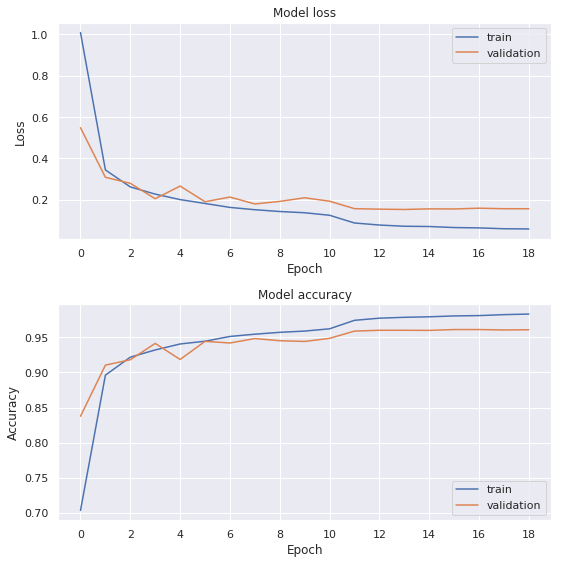

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

acc = hist['sparse_categorical_accuracy']
val_acc = hist['val_sparse_categorical_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

### Predict



In [0]:
out = model.predict(test_data, verbose=1)

214/214 [==============================] - 43s 202ms/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist()

In [0]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score,
    f1_score
)

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
print('Precision: {:.4f}'.format(precision_score(y_pred, y_true, average='macro')))
print('Recall: {:.4f}'.format(recall_score(y_pred, y_true, average='macro')))
print('F1 score: {:.4f}'.format(f1_score(y_pred, y_true, average='macro')))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.9611
Precision: 0.9617
Recall: 0.9636
F1 score: 0.9625


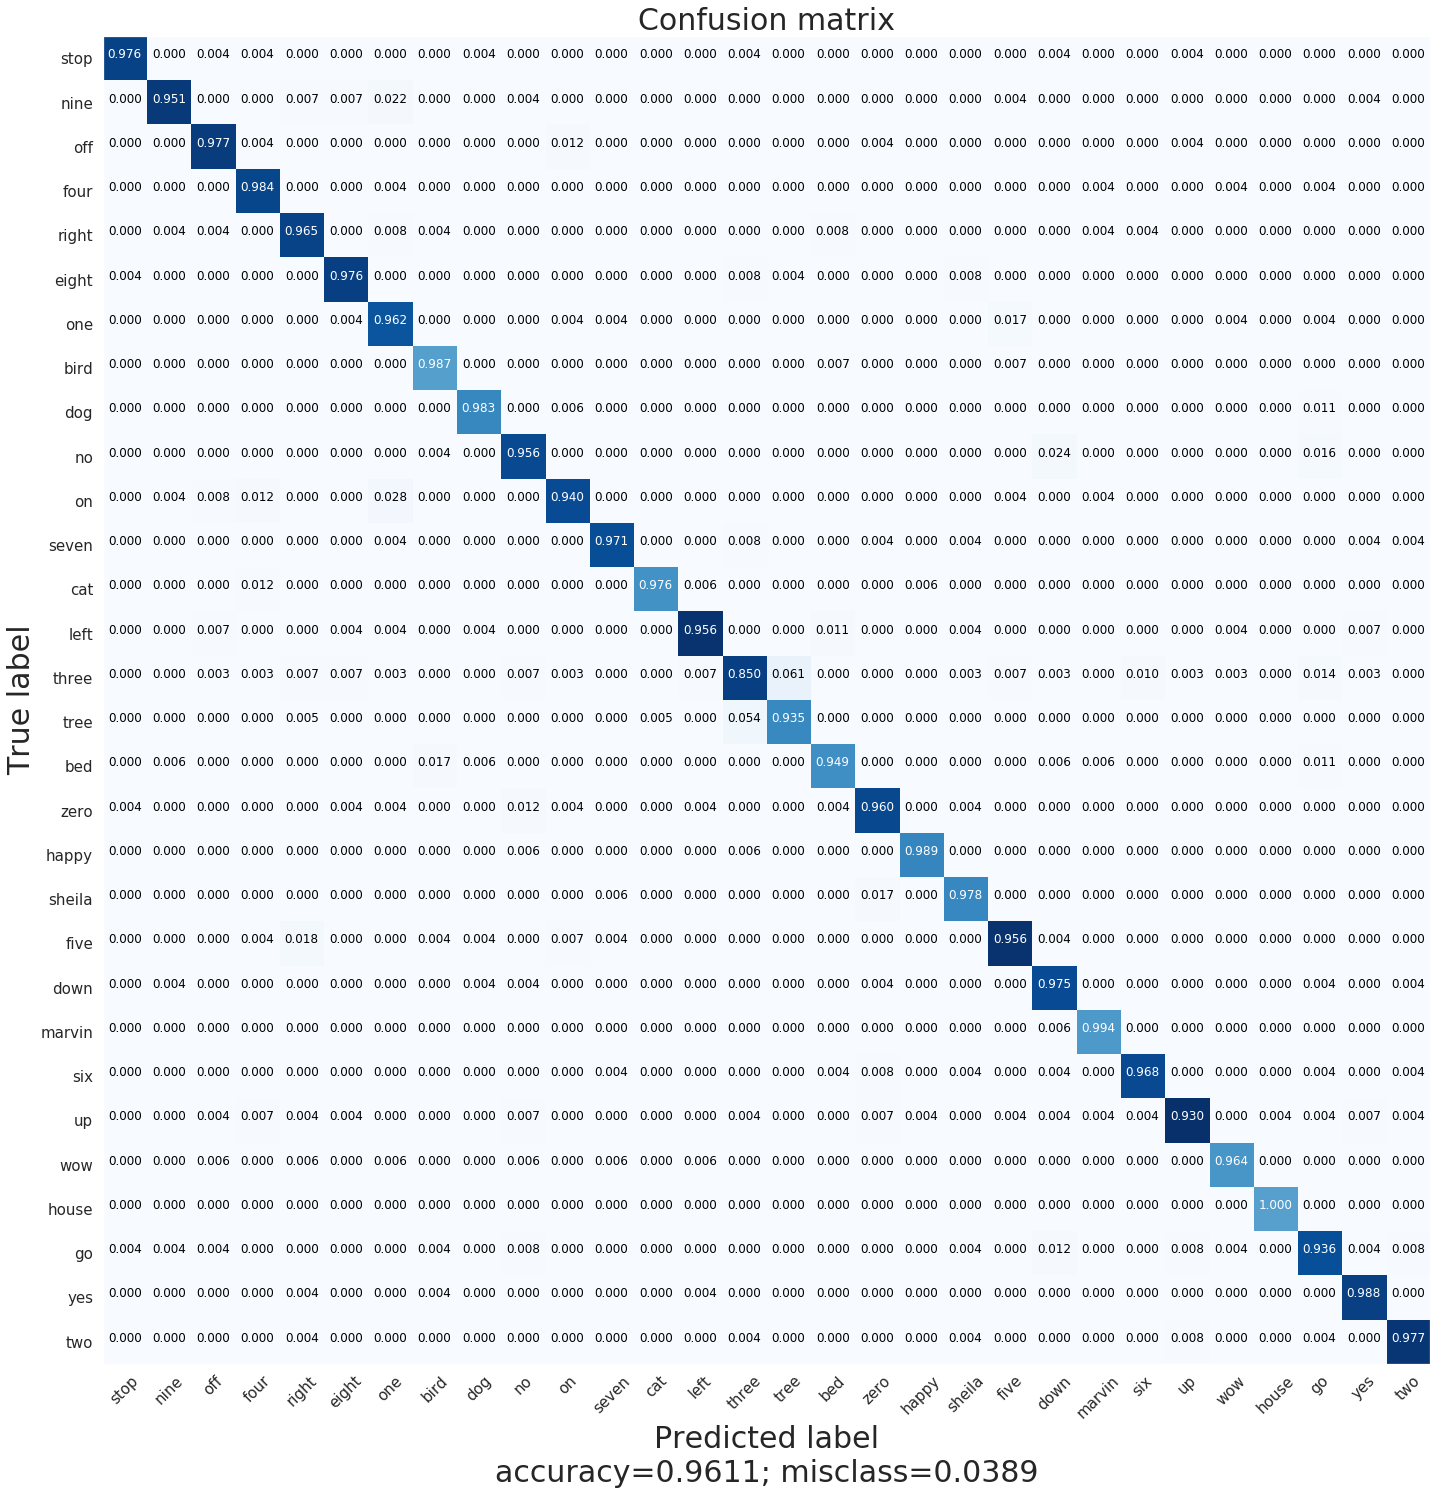

In [0]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)